# Programming Concepts

This week we are focusing on programming concepts that are relevant to scientific computing.  We will first cover the sources of error in our numerical methods and considerations of complexity, which often dictate the algorithm that we use.  Finally, we will discuss the concept of object oriented programming and what that means for Python code development and issues related to scope and namespaces.

**Acknowledgement**: This Notebook incorportates course materials provided by **Zhaohuan Zhu** and **Phil Chang**

## 1. Precision and Round Off Error

When writing code, it is useful to understand how numbers are represented on a computer and the limitations that come with this. In particular, one can only represent a fixed range of numbers or with finite precision, both of which are determined by the number of bits used to represent them.  When doing arithmetic operations on these numbers, the finite precision will lead to errors in the numbers near the precision limit -- such errors are called round off errors.

Both integers and floating point numbers are commonly represented using 32 or 64 bits. Understanding these representations are important for understanding round off errors.

### Integers 

The range of integers one can represent is limited by the number of bits used to store the integer. For example, signed integers range from ($-2^{n-1}$, $2^{n-1}$) where n is the number of bits.
      
Note that in python2 an integer is either 4 bytes or 8 bytes. In python 3, an integer can be any length as long as the memory allows. However, many python libraries (e.g. numpy) don ot support these very long integers.

In [1]:
import numpy as np
a = np.array([1])
print(a.dtype) # default for numpy array is int64 (64 bits)
print(a,bin(a[0])) # bin() returns binary representation

a = np.array([2])
print(a,bin(a[0]))

a=np.array([2**63-1]) # 2^63 - 1 is large int64 (19 digits)
print(a,bin(a[0]))
# adding 1 makes it the smallest representable integer
print(a+1,bin(a[0]+1)) 

int64
[1] 0b1
[2] 0b10
[9223372036854775807] 0b111111111111111111111111111111111111111111111111111111111111111
[-9223372036854775808] -0b1000000000000000000000000000000000000000000000000000000000000000


/var/folders/88/7vcftb255n1gnhcrq9t_ldfc0000gn/T/ipykernel_2356/898443934.py:12: RuntimeWarning: overflow encountered in long_scalars
  print(a+1,bin(a[0]+1))


### Floating point numbers

Representations of floating point numbers are a bit more complicated.  I would recommend reading more about these to understand the representation:  https://en.wikipedia.org/wiki/Single-precision_floating-point_format

Most floating points numbers come in 32 bit (float or float32) and 64 bit (double or float64) precision. The bit distribution of a float and double in memory have the forms (respectively)

ABBBBBBBBCCCCCCCCCCCCCCCCCCCCCCC
ABBBBBBBBBBBCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC

A: sign  
B: exponent (8: float; 11: double)   
C: significand (23 float; 52: double)

These are combined to construct the floating point number. In a double, for example, we have $b_{52-i}$ is the i bit of C; the i of the leftmost C is 1; the i of the rightmost C is 52.

\begin{equation}  
x=(-1)^{sign}\left(1+\sum_{i=1}^{52} b_{52-i}2^{-i}\right)2^{e-1023}
\end{equation}

The maximum number one can represent is set by the number exponent bits. For a float it is $2^{2^7} \approx 10^{38}$ and for a double it is $2^{2^{10}} \approx 10^{308}$.

The precision is determined by the number of bits in the significand. For a float, it is $2^{-24} \approx 6 \times 10^{-8}$ and for a double it is $2^{-53} \approx 10^{-16}$. This means that a float has seven digits of precisions and a double has 15 digits.

**Python floats are 64bit**

In [1]:
import random
import numpy as np
import struct 

# This function is a bit opaque, but it allows us to break the
# floating point number up into a representation that seperates
# sign, exponent, and significand into bit format
def fextract(num):
    return ''.join(bin(c).replace('0b', '').rjust(8, '0') for c in struct.pack('!d', num))

In [3]:
num=1.0 
print(type(num)) # 64 bit in Python
print("%.31f  %s"%(num,fextract(num)[0]+' '+fextract(num)[1:12]+' '+fextract(num)[12:]))

<class 'float'>
1.0000000000000000000000000000000  0 01111111111 0000000000000000000000000000000000000000000000000000


In [4]:
num=0.5
print("%.31f  %s"%(num,fextract(num)[0]+' '+fextract(num)[1:12]+' '+fextract(num)[12:]))

0.5000000000000000000000000000000  0 01111111110 0000000000000000000000000000000000000000000000000000


In [5]:
num=0.75
print("%.31f  %s"%(num,fextract(num)[0]+' '+fextract(num)[1:12]+' '+fextract(num)[12:]))

0.7500000000000000000000000000000  0 01111111110 1000000000000000000000000000000000000000000000000000


In [6]:
num=0.2
print("%.31f  %s"%(num,fextract(num)[0]+' '+fextract(num)[1:12]+' '+fextract(num)[12:]))

0.2000000000000000111022302462516  0 01111111100 1001100110011001100110011001100110011001100110011010


In [7]:
# Left association is important !!! Keep this in mind when you are dealing with round-off errors.
num = 0.2 + 1.9 - 0.3
print("%.31f  %s"%(num,fextract(num)[0]+' '+fextract(num)[1:12]+' '+fextract(num)[12:]))

num = 1.9 + 0.2 - 0.3
print("%.31f  %s"%(num,fextract(num)[0]+' '+fextract(num)[1:12]+' '+fextract(num)[12:]))

num = 0.2 - 0.3 + 1.9
print("%.31f  %s"%(num,fextract(num)[0]+' '+fextract(num)[1:12]+' '+fextract(num)[12:]))

# A+B-C does not equal A-C+B

1.8000000000000000444089209850063  0 01111111111 1100110011001100110011001100110011001100110011001101
1.8000000000000000444089209850063  0 01111111111 1100110011001100110011001100110011001100110011001101
1.7999999999999998223643160599750  0 01111111111 1100110011001100110011001100110011001100110011001100


These may seem like unimportant errors, but sometimes they matter. For example, when you are trying to integrate a system that has some sort of exact symmetry, round off error effects can lead to assymmetries that then grow with time due to truncation error, etc.

Lets look at overflow (maximum float) and underflow (smallest float different from zero). The allowed ranges for a Python float (16 bit) are  [-$10^{308}$, -$10^{-324}$] [$10^{-324}$,10$^{308}$]

In [8]:
num = 1.e-325 #underflow sometimes is treated as 0
print("%.19e  %s"%(num,fextract(num)[0]+' '+fextract(num)[1:12]+' '+fextract(num)[12:]))

0.0000000000000000000e+00  0 00000000000 0000000000000000000000000000000000000000000000000000


In [9]:
num = 1.e-323
print("%.19e  %s"%(num,fextract(num)[0]+' '+fextract(num)[1:12]+' '+fextract(num)[12:]))

9.8813129168249308835e-324  0 00000000000 0000000000000000000000000000000000000000000000000010


In [10]:
num=1.e309 #overflow generates infinity
print("%.19e  %s"%(num,fextract(num)[0]+' '+fextract(num)[1:12]+' '+fextract(num)[12:]))

inf  0 11111111111 0000000000000000000000000000000000000000000000000000


In [11]:
num = 1.7976931348e308
print("%.19e  %s"%(num,fextract(num)[0]+' '+fextract(num)[1:12]+' '+fextract(num)[12:]))

1.7976931347999999853e+308  0 11111111110 1111111111111111111111111111111110110011110001011011


### **Student Completion**

Add a couple lines of code to the body to determine the overflow and underflow
limits to an accuracy within a factor **2**

In [1]:
under = 1.
over = 1.
for i in range(1100):
    ## add your code here
    under /= 2
    over *= 2

    print("Loop number %d, under %25.17e, over %25.17e"%(i,under,over))

Loop number 0, under   5.00000000000000000e-01, over   2.00000000000000000e+00
Loop number 1, under   2.50000000000000000e-01, over   4.00000000000000000e+00
Loop number 2, under   1.25000000000000000e-01, over   8.00000000000000000e+00
Loop number 3, under   6.25000000000000000e-02, over   1.60000000000000000e+01
Loop number 4, under   3.12500000000000000e-02, over   3.20000000000000000e+01
Loop number 5, under   1.56250000000000000e-02, over   6.40000000000000000e+01
Loop number 6, under   7.81250000000000000e-03, over   1.28000000000000000e+02
Loop number 7, under   3.90625000000000000e-03, over   2.56000000000000000e+02
Loop number 8, under   1.95312500000000000e-03, over   5.12000000000000000e+02
Loop number 9, under   9.76562500000000000e-04, over   1.02400000000000000e+03
Loop number 10, under   4.88281250000000000e-04, over   2.04800000000000000e+03
Loop number 11, under   2.44140625000000000e-04, over   4.09600000000000000e+03
Loop number 12, under   1.22070312500000000e-04, o

Now lets experiment with the machine precision: 

In [2]:
num = 1.0e-17
print("%.31f  %s"%(num,fextract(num)[0]+' '+fextract(num)[1:12]+' '+fextract(num)[12:]))

0.0000000000000000100000000000000  0 01111000110 0111000011101111010101000110010001101101010010010111


In [3]:
num = 1.0 + 1.0e-17
print("%.31f  %s"%(num,fextract(num)[0]+' '+fextract(num)[1:12]+' '+fextract(num)[12:]))

1.0000000000000000000000000000000  0 01111111111 0000000000000000000000000000000000000000000000000000


In [4]:
num1 = 100.1
num2 = 100.1+100.*1.0e-17
print("%.31f %.31f"%(num1,num2))

100.0999999999999943156581139191985 100.0999999999999943156581139191985


### **Student Completion**

Modify the code to determine the machine precision to within a factor of **2**.

In [5]:
eps = 1
for i in range(100):
    ## add your code here
    eps /= 2.
    ##
    print('eps=',eps,' one_plus_eps',1+eps)

eps= 0.5  one_plus_eps 1.5
eps= 0.25  one_plus_eps 1.25
eps= 0.125  one_plus_eps 1.125
eps= 0.0625  one_plus_eps 1.0625
eps= 0.03125  one_plus_eps 1.03125
eps= 0.015625  one_plus_eps 1.015625
eps= 0.0078125  one_plus_eps 1.0078125
eps= 0.00390625  one_plus_eps 1.00390625
eps= 0.001953125  one_plus_eps 1.001953125
eps= 0.0009765625  one_plus_eps 1.0009765625
eps= 0.00048828125  one_plus_eps 1.00048828125
eps= 0.000244140625  one_plus_eps 1.000244140625
eps= 0.0001220703125  one_plus_eps 1.0001220703125
eps= 6.103515625e-05  one_plus_eps 1.00006103515625
eps= 3.0517578125e-05  one_plus_eps 1.000030517578125
eps= 1.52587890625e-05  one_plus_eps 1.0000152587890625
eps= 7.62939453125e-06  one_plus_eps 1.0000076293945312
eps= 3.814697265625e-06  one_plus_eps 1.0000038146972656
eps= 1.9073486328125e-06  one_plus_eps 1.0000019073486328
eps= 9.5367431640625e-07  one_plus_eps 1.0000009536743164
eps= 4.76837158203125e-07  one_plus_eps 1.0000004768371582
eps= 2.384185791015625e-07  one_plus_eps 1.

In [6]:
# round off error in operations
num1 = 0.1
num2 = 0.2
num3 = 0.3
print("%.31f %.31f %.31f %.31f"%(num1, num2, num1+num2, num3))
print("The relative error of the difference is ",abs((num1+num2)/num3-1))

0.1000000000000000055511151231258 0.2000000000000000111022302462516 0.3000000000000000444089209850063 0.2999999999999999888977697537484
The relative error of the difference is  2.220446049250313e-16


In [7]:
num1 = 0.2000000000001
num2 = 0.2
num3 = 0.0000000000001
print("%.31f %.31f %.31f %.31f"%(num1,num2, num1-num2, num3))
print("The relative error of the difference is ",abs((num1-num2)/num3-1))

0.2000000000000999866855977415980 0.2000000000000000111022302462516 0.0000000000000999755833674953465 0.0000000000001000000000000000030
The relative error of the difference is  0.00024416632504653535


## 2 Performance

Sometimes, all we care about is getting a task done correctly.  We just need to make a plot or do a simple calculation.  But, many things astronomers do require hard, time-consuming calculations.  So the performance of the calculation method can matter. There is lots of research done on developming more accurate and computationally less expensive (fewer operations) algorithms.

Lets consider computation of the Fibonacci  sequence as an example.

Fibonacci number
The number series: 1, 1, 2, 3, 5, 8, 13, 21, 34, ...
\begin{equation}
F_{n}=F_{n-1}+F_{n-2}
\end{equation}
What is $F_{n}$?

There are several different method for doing this.

### Recursion methods

Recursion in computer science is a method of solving a problem where the solution depends on solutions to smaller instances of the same problem.

Most computer programming languages support recursion by allowing a function to call itself from within its own code. Recursion is often an example of the dynamic program -- an algorithmic paradigm that solve a more complex problem by breaking it down into simpler subproblems 

## **Student Completion**

Write your own fibonacci function using recursion

In [8]:
# Recursion
def fibr(n):
    if n == 0:
        return 1
    elif n == 1:
        return 1
    else:
        return fibr(n-1) + fibr(n-2)

In [30]:
n = 30 # start with ~30 and then increase it!
%time print(fibr(n))

1346269
CPU times: user 186 ms, sys: 3 ms, total: 189 ms
Wall time: 188 ms


This method is simple to implement but runs into problems because the exponential growth in the computational time with n.

### Memorization method (top down)

This employs an optimization technique used primarily to speed up computer programs by storing the results of expensive function calls and returning the cached result when the same inputs occur again.

In [18]:
# Assumes we have defined an array table = [None]*(n+1)

# Store the data we already calculated, linear space and time complexity, but
# still subject to stack limit

def fibm(n, table):
    if n == 0 or n==1:
        table[n] = n
    
    # if the value has not been calculated, calculate it 
    if table[n] is None:
        table[n] =  fibm(n-1, table) + fibm(n-2, table)
        
    return table[n]

In [37]:
table = [None]*(11)
print(fibm(10, table))

n = 15
table = [None]*(n+1)
%time print(fibm(n, table))

# calculate time if n=150, 1500, 15000
n = 150
table = [None]*(n+1)
%time print(fibm(n, table))

n = 1500
table = [None]*(n+1)
%time print(fibm(n, table))

55
610
CPU times: user 28 μs, sys: 0 ns, total: 28 μs
Wall time: 31 μs
9969216677189303386214405760200
CPU times: user 0 ns, sys: 140 μs, total: 140 μs
Wall time: 144 μs
13551125668563101951636936867148408377786010712418497242133543153221487310873528750612259354035717265300373778814347320257699257082356550045349914102924249595997483982228699287527241931811325095099642447621242200209254439920196960465321438498305345893378932585393381539093549479296194800838145996187122583354898000
CPU times: user 303 μs, sys: 418 μs, total: 721 μs
Wall time: 727 μs


In [39]:
# This one should give a recursion limit error due to exceeding
# the size of the call stack
n = 15000
table = [None]*(n+1)
%time print(fibm(n, table))

CPU times: user 1.24 ms, sys: 1 ms, total: 2.24 ms
Wall time: 2.26 ms


RecursionError: maximum recursion depth exceeded

The performance is much better than with simple recurssion, but we are still limited by the size of the call stack -- the number of stored operations that the Python interpreter needs to keep track of.

### Tabulation Method (bottom-up)

Calculate all the values from small to big. This method avoids recursion and is both faster and not limited by the size of the call stack.

In [40]:
# calculate numbers one by one from table[2] to table[n]

def fibt(n):
    table = [0]*(n+1)
    table[1] = 1
    for i in range(2, n+1):
        table[i] = table[i-1] + table[i-2]
    # try this: please finish the following two lines calcuating table[i] from table[i-1] and table[i-2]
        
    return table[n]

In [43]:
print(fibt(10))
#import time
#start_time = time.time()
%time print(fibt(150))
#print("--- %s seconds ---" % (time.time() - start_time))
#start_time = time.time()
%time print(fibt(1500))
#print("--- %s seconds ---" % (time.time() - start_time))
#start_time = time.time()
%time print(fibt(15000)) 
#print("--- %s seconds ---" % (time.time() - start_time))

55
9969216677189303386214405760200
CPU times: user 40 μs, sys: 1 μs, total: 41 μs
Wall time: 43.4 μs
13551125668563101951636936867148408377786010712418497242133543153221487310873528750612259354035717265300373778814347320257699257082356550045349914102924249595997483982228699287527241931811325095099642447621242200209254439920196960465321438498305345893378932585393381539093549479296194800838145996187122583354898000
CPU times: user 237 μs, sys: 0 ns, total: 237 μs
Wall time: 240 μs
2918224824204913830236407223698513202230962655711828774617138735156624458079183128895718558218554430571700189155441406738131392889920065194454205115225018718391296972560850649470565039095298541589328722018752013996671288484179383148494515128025196080868823259734941860479438251159769171183937475043926533682459371729417083036155111469356511900052820298859112265364211898572296023436366156951405784120646301849570311694258743813333067821998545184787038412434385590019619424764197160494314613988520689374965327024847823

## 3 Complexity

Algorithm complexity is a measure which evaluates the order of the count of operations, performed by a given or algorithm as a function of the size of the input data. Roughly speaking, complexity is a rough approximation of the number of steps necessary to execute an algorithm. When we evaluate complexity we speak of the order of the operation count, not of the exact count. 

For example if we have an order of $N^2$ operations to process N elements, then $N^2$/2 and 3*$N^2$ are of one and the same quadratic order.

Algorithm complexity is commonly represented with the O(f) notation e.g. O($N^2$)

n=1: 0.000000 seconds
n=4: 0.000002 seconds
n=7: 0.000007 seconds
n=10: 0.000031 seconds
n=13: 0.000129 seconds
n=16: 0.000561 seconds
n=19: 0.002351 seconds
n=22: 0.009969 seconds
n=25: 0.042304 seconds
n=28: 0.179909 seconds
n=31: 0.756952 seconds
n=34: 3.209428 seconds
n=37: 13.590116 seconds


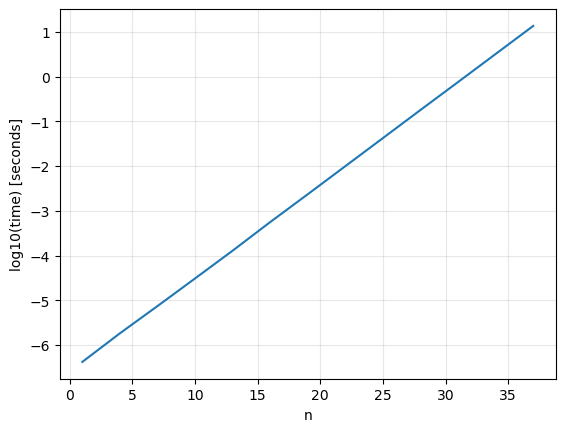

In [46]:
import numpy as np
import matplotlib.pyplot as plt

n2 = np.arange(1, 38, 3)
time2 = np.zeros(n2.size)

# Warmup run (to elimiate overhead for first run)
_ = fibr(10)

for i in range(n2.size):
    result = %timeit -n 1 -r 3 -q -o fibr(n2[i])
    time2[i] = result.best
    print(f"n={n2[i]}: {time2[i]:.6f} seconds")

plt.plot(n2, np.log10(time2))
plt.xlabel('n')
plt.ylabel('log10(time) [seconds]')
plt.grid(True, alpha=0.3)
plt.show()

Now lets try it using fibt(), but got to n2 = 3000

n=1: 0.000001 seconds
n=11: 0.000002 seconds
n=21: 0.000004 seconds
n=31: 0.000003 seconds
n=41: 0.000006 seconds
n=51: 0.000008 seconds
n=61: 0.000008 seconds
n=71: 0.000010 seconds
n=81: 0.000010 seconds
n=91: 0.000014 seconds
n=101: 0.000015 seconds
n=111: 0.000015 seconds
n=121: 0.000015 seconds
n=131: 0.000018 seconds
n=141: 0.000019 seconds
n=151: 0.000022 seconds
n=161: 0.000023 seconds
n=171: 0.000025 seconds
n=181: 0.000023 seconds
n=191: 0.000026 seconds
n=201: 0.000029 seconds
n=211: 0.000031 seconds
n=221: 0.000030 seconds
n=231: 0.000030 seconds
n=241: 0.000032 seconds
n=251: 0.000035 seconds
n=261: 0.000035 seconds
n=271: 0.000041 seconds
n=281: 0.000042 seconds
n=291: 0.000045 seconds
n=301: 0.000039 seconds
n=311: 0.000049 seconds
n=321: 0.000050 seconds
n=331: 0.000051 seconds
n=341: 0.000052 seconds
n=351: 0.000054 seconds
n=361: 0.000053 seconds
n=371: 0.000057 seconds
n=381: 0.000063 seconds
n=391: 0.000066 seconds
n=401: 0.000058 seconds
n=411: 0.000056 seconds
n=4

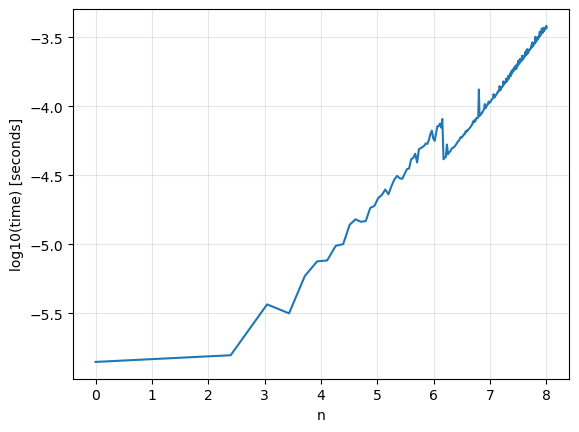

In [49]:
import numpy as np
import matplotlib.pyplot as plt

n2 = np.arange(1, 3000, 10)
time2 = np.zeros(n2.size)

# Warmup run (to elimiate overhead for first run)
_ = fibr(10)

for i in range(n2.size):
    result = %timeit -n 1 -r 3 -q -o fibt(n2[i])
    time2[i] = result.best
    print(f"n={n2[i]}: {time2[i]:.6f} seconds")

plt.plot(np.log(n2), np.log10(time2))
plt.xlabel('n')
plt.ylabel('log10(time) [seconds]')
plt.grid(True, alpha=0.3)
plt.show()

This plot will likely be a bit noisy, but the result should be approximately linear for sufficiently large n.  A linear relation in a log-log plot is indicative of power law (simple polynomial) relation. In this case the slope is nearly one so that $t \propto n^1$ or a linear relation. One can confirm this by ploting n2 verus time2 instead of the log of each.

### Algorithm Selection and Complexity

Complexity matters for any problem where $N$ is large.  In astronomy we are often dealing with big data sets, images with lots pixels, or large computational domains.  Most commonly used algorithms and methods have known complexity so you can evaluate the merits of different choices.  The difference between alogirthms that scale as $O(N)$ and $O(\log N)$ may not seem like much but they can reduce run times by factors of hundreds, thousands, or even more depending on the program size.  Hence, lots of effort has gone into finding new or modified algorithms that reduce the complexity of different tasks.

Usually one wants to use the algorithm with the lowest complexity, but this may not always be the case.  Sometimes the lower complexity algorithms are much more complicated to implement, or are only valid/effective on restricted problems.  Also, complexity only tells you about scaling with $N$. Some algorithms with reduced complexity may have a lot of overhead and may actually take more time to run at low or moderate values of $N$.  It is important to consider all of these factors when choosing an algorithm, but most of the time, the lower complexity algorithm is the right choice.

## 3 Truncation Error

Truncation error is the error made by   
1) truncating an infinite sum and approximating it by a finite sum   
2) discretization error: error due to taking a finite number for steps instead of an infinite number

Truncation error often arises in the intergration of differential equations.  It is not to be confused with the round off error discussed above. Truncation error is a result of the approximation made in the algorithm while round off error is determined by the limitations of the representation of the number on computer hardware.

### Differentiation

Differentiation is a mathematical operation that we commonly use for all sorts of scientific applications.  Imagine we are given the trajectory of an object $y$ at a set of tabluated times $t$ and we want to compute the velocity of the object at these times. We need to calculate ${\bf v} = dy(t)/dt $. 

Formally, it is $dy(t)/dt=\lim_{\Delta t-> 0}\frac{y(t+\Delta t)-y(t)}{\Delta t}$. Clearly the smaller we make $h$, the better approximation we get. But we are limited by machine precision, but also by the fact that we can only tabulate the trajectory at a finite number of times.  As we increase the number tabulations, the number of derivatives we have to compute goes up.  There is a trade off between taking smaller steps in time and computational cost. Since e have to take a finite $h$, we have to live with truncation error.

There is no single best way to represent a derivative, but multiple possibilities with different strengths and weaknesss. The optimal representation may depend on the details of the underlying problem you are trying to solve.  Lets take the first derivative for a concrete example

A common approximation is the **forward difference**:
\begin{equation}
\frac{d y(t)}{dt} \Bigg|_{fw} = \frac{y(t+h)-y(t)}{h}
\end{equation}
Here $h$ represents finite step in time.

We can estimate the error using the Taylor series expansion
\begin{equation}
y(t+h)=y(t)+h y'(t)+\frac{h^2}{2!} y''(t)+\frac{h^3}{3!} y'''(t)+...
\end{equation}
So
\begin{equation}
\frac{d y(t)}{dt}\Bigg|_{fw} = y'(t)+\frac{h}{2!}y''(t)+\frac{h^2}{3!}y'''(t)+...
\end{equation}
Hence, the error is $\frac{h}{2!}y''(t)+\frac{h^2}{3!}y'''(t)+...$, the leading error is O(h). This means that as we reduce $h$, the error will get smaller by a factor proportional to $h$, or first order.

Another options is the **central difference**:
\begin{equation}
\frac{d y(t)}{dt}\Bigg|_{cd} = \frac{y(t+h/2)-y(t-h/2)}{h}
\end{equation}

Again we use a Taylor series to check the error
\begin{equation}
y(t+h/2)=y(t)+h/2y'(t)+\frac{(h/2)^2}{2!}y''(t)+\frac{(h/2)^3}{3!}y'''(t)+\frac{(h/2)^4}{4!}y^{(4)}(t)+\frac{(h/2)^5}{5!}y^{(5)}(t)+.... 
\end{equation}
\begin{equation}
y(t-h/2)=y(t)-h/2y'(t)+\frac{(h/2)^2}{2!}y''(t)-\frac{(h/2)^3}{3!}y'''(t)+\frac{(h/2)^4}{4!}y^{(4)}(t)-\frac{(h/2)^5}{5!}y^{(5)}(t)+....
\end{equation}
So  
\begin{equation}
\frac{d y(t)}{dt}\Bigg|_{cd} = y'(t) + \frac{h^2}{4*3!}y'''(t)+\frac{h^4}{2^4*5!}y^{(5)}(t)....
\end{equation}
So the error is $O(h^2)$, or second order. 

We can extend the method to even higher order accuracy using a method called Richardson Extraploation. Consider two different central difference representations:
\begin{equation}
\frac{d y(t)}{dt}\Bigg|_{cd,1} = \frac{y(t+h/2)-y(t-h/2)}{h}
\end{equation}
\begin{equation}
\frac{d y(t)}{dt}\Bigg|_{cd,2} = \frac{y(t+h/4)-y(t-h/4)}{h/2}
\end{equation}
So  
\begin{equation}
\frac{d y(t)}{dt}\Bigg|_{cd,1} = y'(t) + \frac{h^2}{2^3/2*3!}y'''(t) + \frac{h^4}{2^5/2*5!}y^{(5)}(t)....
\end{equation}
\begin{equation}
\frac{d y(t)}{dt}\Bigg|_{cd,2} = y'(t) + \frac{h^2}{4^3/4*3!}y'''(t) + \frac{h^4}{4^5/4*5!}y^{(5)}(t)....
\end{equation}
Then we have
\begin{equation}
\frac{d y(t)}{dt}\Bigg|_{ed} = \frac{4\frac{d y(t)}{dt}\bigg|_{cd,2}-\frac{d y(t)}{dt}\bigg|_{cd,1}}{3}=\frac{8[y(t+h/4)-y(t-h/4)]-[y(t+h/2)-y(t-h/2)]}{3 h}
\end{equation}
So the error is $O(h^4)=-\frac{h^4}{64*120}y^{(5)}(t)....$.  Note that we need to use more tabulations of y(t) to achieve this higher order representation for the derivative.

In [50]:
import numpy as np

# note that y is a fucntion
def derifw(y,x,dx):
    return (y(x+dx)-y(x))/dx

def dericd(y,x,dx):
    return (y(x+dx/2)-y(x-dx/2))/dx

**Python lets you pass functions as arguments to other functions**

## **Student Completion**

Make your own representation for the extrapolated difference using the above definition.

In [51]:
def deried(y,x,dx):
    ## write your own extrapolated difference scheme
    return (8*y(x+dx/4)-8*y(x-dx/4)-y(x+dx/2)+y(x-dx/2))/3/dx

In [52]:
x = 1.0
dx = 0.1
print('forward difference',derifw(np.sin,x,dx)) # np.sin is a function
print('central difference',dericd(np.sin,x,dx))
print('extrapolated difference',deried(np.sin,x,dx))
print('analytical result',np.cos(x))

forward difference 0.4973637525353891
central difference 0.5400772080464322
extrapolated difference 0.5403022988334757
analytical result 0.5403023058681398


In [54]:
# Now check how errors change with dx
import numpy as np
x = 1.0
dxarr1 = []
yarr1 = []
for dx in 10**np.arange(-8, -0.5, 0.1):
    y = derifw(np.sin,x,dx)
    print('dx %g,  y %g'%(dx,y))
    dxarr1.append(dx)
    yarr1.append(y)

dx 1e-08,  y 0.540302
dx 1.25893e-08,  y 0.540302
dx 1.58489e-08,  y 0.540302
dx 1.99526e-08,  y 0.540302
dx 2.51189e-08,  y 0.540302
dx 3.16228e-08,  y 0.540302
dx 3.98107e-08,  y 0.540302
dx 5.01187e-08,  y 0.540302
dx 6.30957e-08,  y 0.540302
dx 7.94328e-08,  y 0.540302
dx 1e-07,  y 0.540302
dx 1.25893e-07,  y 0.540302
dx 1.58489e-07,  y 0.540302
dx 1.99526e-07,  y 0.540302
dx 2.51189e-07,  y 0.540302
dx 3.16228e-07,  y 0.540302
dx 3.98107e-07,  y 0.540302
dx 5.01187e-07,  y 0.540302
dx 6.30957e-07,  y 0.540302
dx 7.94328e-07,  y 0.540302
dx 1e-06,  y 0.540302
dx 1.25893e-06,  y 0.540302
dx 1.58489e-06,  y 0.540302
dx 1.99526e-06,  y 0.540301
dx 2.51189e-06,  y 0.540301
dx 3.16228e-06,  y 0.540301
dx 3.98107e-06,  y 0.540301
dx 5.01187e-06,  y 0.5403
dx 6.30957e-06,  y 0.5403
dx 7.94328e-06,  y 0.540299
dx 1e-05,  y 0.540298
dx 1.25893e-05,  y 0.540297
dx 1.58489e-05,  y 0.540296
dx 1.99526e-05,  y 0.540294
dx 2.51189e-05,  y 0.540292
dx 3.16228e-05,  y 0.540289
dx 3.98107e-05,  y 0

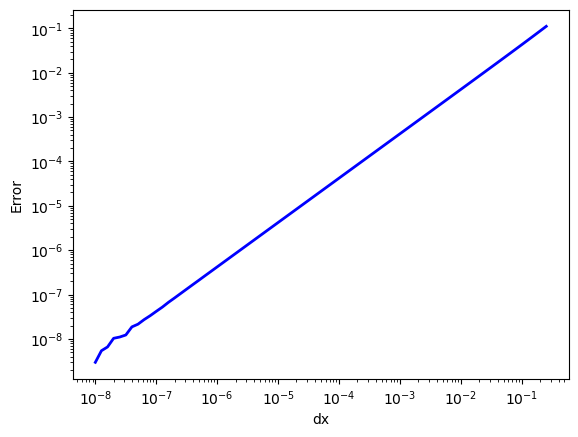

In [57]:
import matplotlib.pyplot as plt
    
plt.xscale('log') # sets the axis scale logarithmically
plt.yscale('log')
plt.xlabel('dx') # sets the caption of the axis label
plt.ylabel('Error')
plt.plot(dxarr1, abs(yarr1-np.cos(1.)), 'b-', lw=2);

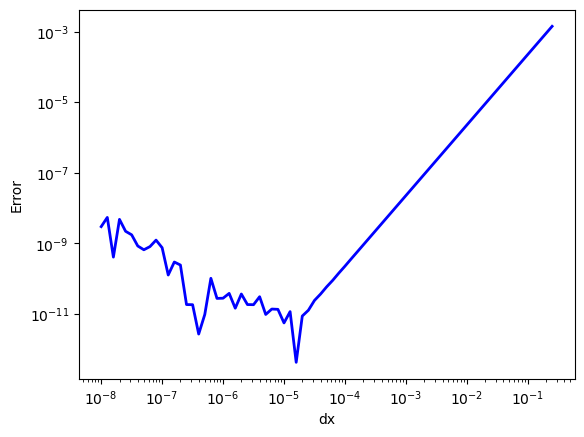

In [59]:
x = 1.0
dxarr2 = []
yarr2 = []
for dx in 10**np.arange(-8., -0.5, 0.1):
    y = dericd(np.sin,x,dx)
    dxarr2.append(dx)
    yarr2.append(y)
       
plt.xscale('log')
plt.yscale('log')
plt.xlabel('dx')
plt.ylabel('Error')
plt.plot(dxarr2, abs(yarr2-np.cos(x)), 'b-', lw=2);

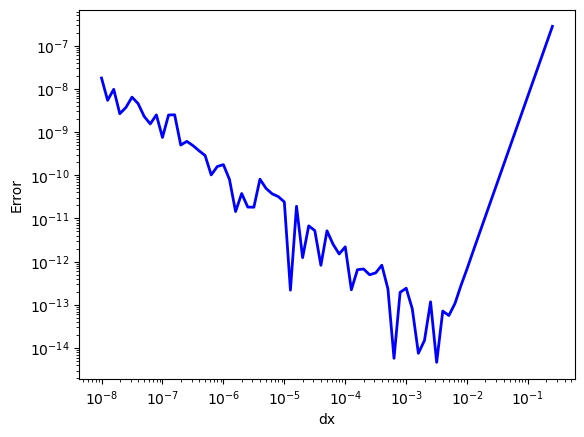

In [61]:
x = 1.0
dxarr3 = []
yarr3 = []
for dx in 10**np.arange(-8., -0.5, 0.1):
    y = deried(np.sin,x,dx)
    dxarr3.append(dx)
    yarr3.append(y)
       
plt.xscale('log')
plt.yscale('log')
plt.xlabel('dx')
plt.ylabel('Error')
plt.plot(dxarr3, abs(yarr3-np.cos(x)), 'b-', lw=2);

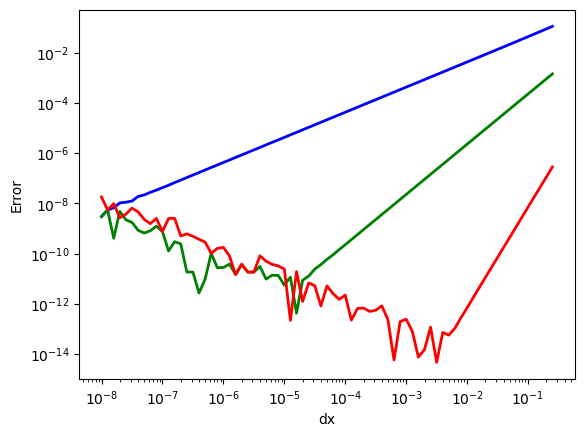

In [62]:
# Not plot them all together

plt.xscale('log')
plt.yscale('log')
plt.xlabel('dx')
plt.ylabel('Error')
plt.plot(dxarr1, np.abs(yarr1-np.cos(1.)), 'b-', lw=2)  
plt.plot(dxarr2, np.abs(yarr2-np.cos(1.)), 'g-', lw=2)  
plt.plot(dxarr3, np.abs(yarr3-np.cos(1.)), 'r-', lw=2);

### Error Assessment

**A higher order scheme gets a more accurate result with a bigger step size.**

But, why do the errors stop getting smaller with $dx$?  Before reading further, give it some thought and see if you can figure it out yourself.
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
The answer is round off error.

The best results you can get is that the addtion of the round-off error and the truncation error is minimum. Since the truncation error decreases as h becomes small and the round-off error increases as h becomes small (subtraction cancellation), it means that the round-off error roughly equals the truncation error.

The round-off error for the difference $[y(t+h)-y(t)]$ is $\approx \epsilon_{machine} y(t)$ when $h$ is sufficiently small, so the error for $([y(t+h)-y(t)])/h$ is $y\times\epsilon_{machine}/h$. On the other hand, the truncation error for forward difference is $y''\times h/2$, for central difference is $y'''\times h^2/24$.


Assuming that $y\sim y'\sim y''$ (reasonable to an order of magnitude for the problem above) and $\epsilon_{machine}\sim 10^{-15}$. We find $h_{\rm min}$ by setting the truncation error equal to round off error (e.g. $10^{-15}\times y / h_{\rm min} \simeq y'' h_{\rm min}/2$. For a forward difference is we have $h_{\rm min} \sim 10^{-8}$ and for a central difference is $h_{\rm min} \sim 10^{-5}$.

**More importantly**, the limiting error for these $h_{\rm min}$ values for forward difference is $10^{-8}$ and for the central difference is $10^{-11}$. Higher order methods can generally achieve more accuracy before round off error becomes dominant.

## 4 Scope and Namespace

When working through Python code, it is important to understand the scope of the objects you are manipulating.  If you don't you will likely run into trouble.

A namespace is a mapping of names to objects. In Python and other languages, you can often have more than one name for the same object, but each name uniquely points to one object within a given namespace.  This is because the interpreter (or compiler) needs to know which object you are referring to.  That said, it may be convenient to use a common name (e.g. data, plot, i, j, k, etc.) in different parts of a code that are logically seperated from each other.

Programming languages accomplish this by supporting multiple concurrent namespaces.  The relatinoship between namespaces is handle by scope rules. A variable's scope is the region within the program in which it is visible.

The most universal namespace within Python is the namespace of the built-in functions (e.g. `abs()`) and constants (e.g. `None`).  The next important namespace is the global namespace of the module or script. Any variable defined outside of a function is global within the module. This is also true for variables defined outside of functions in scripts and interactive sessions within the interpreter, since these belong to the `__main__` module.  Next, we have the local namespaces within the functions.  These can be nested due functions being defined within other functions.  When Python tries to find which object matches the variable name, it first checks most local namespace, then works its way outward through the nested functions, and then onto the modules global namespace. It never searches the opposite way!  One cannot see the variables within a function from outside that function.

The easiest way to understand this is through some examples.

In [73]:
test = "global"

def scope_test1():
    test = "local"
    print(test)

def scope_test2():
    print(test)

def scope_test3():
    test = "local"
    def sub_test():
        test = "sub"
        print(test)

    sub_test()

def scope_test4():
    test = "local"
    def sub_test():
        print(test)

    sub_test()

scope_test1() # returns local
scope_test2() # returns global
scope_test3() # returns sub
scope_test4() # returns local

local
global
sub
local


In `scope_test1()` we create a new object when we set `test` that is different from the global variable defined outside of the function.  In `scope_test2()`, we have not assigned any variable with the name `test` so it looks in the global namespace of the module.  In `scope_test3()`, `print()` is called inside `sub_test()` where have assigned `test` the value "sub". In `scope_test4()` we have not defined `test` within `sub_test()`.  Hence, the scope rules say the interpreter should next look for `test` wthin `scope_test4()`.  Finding such an assignment, it prints "local".

Python provides two statements that allow one to override these scope rules.  These are `global` and `nonlocal`. `global` tells Python to use the variable in the module's global namespace.  `nonlocal` tells it to search the namespace in which current function was defined.

In [74]:
def scope_test():
    def set_local():
        test = "local"

    def set_nonlocal():
        nonlocal test
        test = "nonlocal"

    def set_global():
        global test
        test = "global"

    test = "scope_test"
    
    set_local()
    print("local assignment:", test)
    set_nonlocal()
    print("nonlocal assignment:", test)
    set_global()
    print("global assignment:", test)

scope_test()
print("in global scope:", test)

local assignment: scope_test
nonlocal assignment: nonlocal
global assignment: nonlocal
in global scope: global


We set `test` to be "scope_test" within the `scope_test()` function.  When we assign `test` in `set_local()` it does not impact this definition.  When we assign `test` in `set_nonlocal()` the `nonlocal` statement specifies that we treat `test` as corresponding to the same object assigned in `scope_test()` and it is changed.  When we next call `set_global()` the `global` statement tells us that `test` corresponds to the variable in global scope.  Hence the `test` variable within the `scope_test()` function is unchanged and still prints "nonlocal".  Finally, when we print `test` outside of `scope_test()` we confirm that our assignment in `set_global()` changed the value of `test` in global scope.

Python provides two built-in functions to help with scope resolution `globals()` and `locals()` that return the list of variables in local and global scope as a dictionaries.

In [ ]:
a = 5
def some_function():
    b = 3
    print('a' in locals()) # False
    print('b' in locals()) # True
    print('a' in globals()) # True
    print('b' in globals()) # False

some_function()

def some_other_function():
    a = 3
    print('a' in locals()) # True
    print('a' in globals()) # True
    print(a) # 3
    
some_other_function()
print(a) # 5


### Passing of Arguments to Functions

A general concern for most programming languages how variables are passed to functions.  The two most common approaches are pass by value and pass by reference. In pass by value, a copy of the variable is created. In pass by reference, the corresponding variable name is set to point to the same object (memory location). This means that changes to the variable within the function will persist even after the function returns.

In [ ]:
# pass by value (sort of)
def change_val(y):
    y += 1
    print("in func:", y)

x = 2
change_val(x)
print(x)

# pass by reference (sort of)
a = [2, 3, 4]

def appendto(b):
    b.append(5)

appendto(a)
print(a)

# pass by value (sort of)
def double(b):
    b = b * 2
    print(b)
    
double(a)
print(a)

In the first example, `y` is just another name for `x` initially, but when the `+=` operater reassigns `y` to a new value, it breaks this link and creates a new variable.  So the behavior is similar to pass by value and the value of `x` in the global scope is not changed.  In the second example *there is no reassignment* so Python treats `b` as the same object as `a` in global scope and the appended 5 persists even after the function returns.  In the third example there is again a *reassignment* which creates a new object.  Hence, `a` in global scope remains unchanged.

Hence, Python is neither purely pass-by-reference or a pass-by-value.  It is sometimes referred to as "pass-by-assignment". The outcome depends on what you do within the function.

## 5. Object Oriented Programming

As discussed in last week's lecture, OOP is way of designing code that focusses on creating classes with attributes and methods.  Most Python packages operated this way.  Think of the ndarry class in NumPy.

### An example

Lets say we want to make a plot of the sine function using matplotlib.  We can do this many different ways.

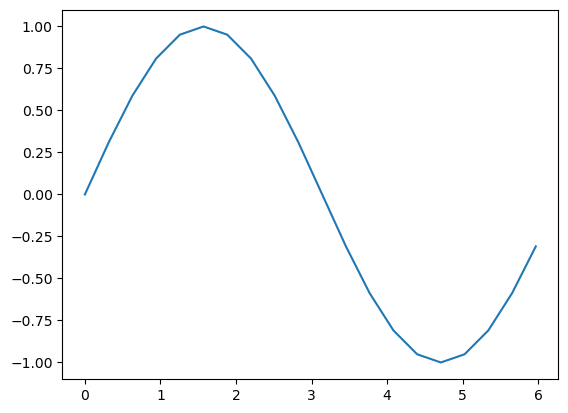

In [63]:
import matplotlib.pyplot as plt
import numpy as np
# function focussed approach
x = np.arange(0,2*np.pi,2.*np.pi/20)
y = np.sin(x)

plt.plot(x,y);

This follows functional programming paradigm.  We have created two arrays for inputs (allow we used a ndarray method to do so!) and then called a `plot` function to do the plotting.

<class 'matplotlib.figure.Figure'>
<class 'matplotlib.axes._axes.Axes'>


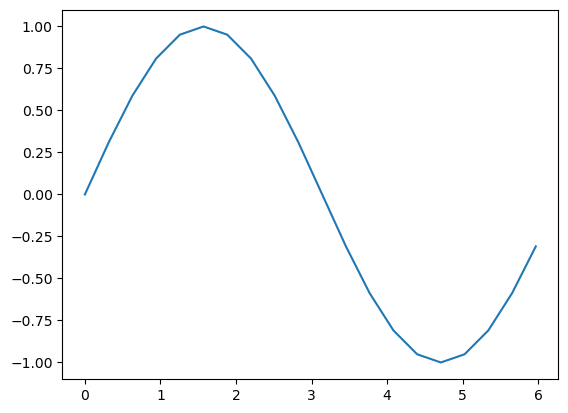

In [64]:
import matplotlib.pyplot as plt
import numpy as np
# OOP approach
x = np.arange(0,2*np.pi,2.*np.pi/20)
y = np.sin(x)

fig, ax = plt.subplots()
print(type(fig))
print(type(ax))
ax.plot(x,y);

You may be thinking that is just more things to type. But the return of creating objects is that we can now use pyplots's methods to modify our `fig` and `ax` instances. But, if you want to construct a more complex figure with many subplots, the OOP approach makes it much easier to build up the figure by successively modifying the instances before generating the final versino of the plot.

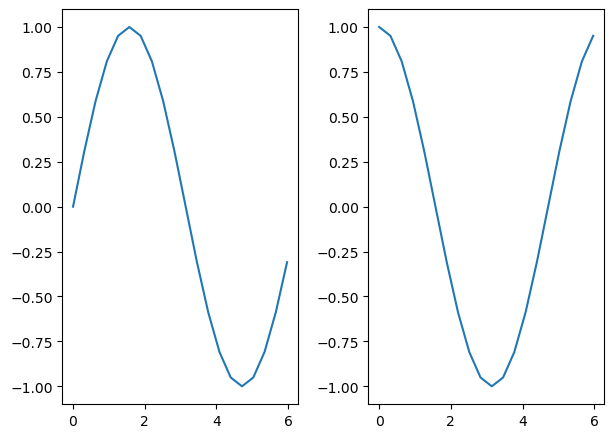

In [66]:
x = np.arange(0,2*np.pi,2.*np.pi/20)
y = np.sin(x)
z = np.cos(x)

fig, axs = plt.subplots(1,2) # fig w/ 2 subplots
fig.tight_layout(pad=2) # control the subplot spacing
axs[0].plot(x,y) # first subplot
axs[1].plot(x,z); # second subplot

### Creating New Classes

Creating a new class in Python is easy

In [67]:
# This is a pretty useless class
class empty:
    pass

x = empty()
print(type(x))
print(x.__dict__) # is there anything in here?

<class '__main__.empty'>
{}


In [68]:
# but we can still add to it!
x.q = 1
print(x.__dict__)

{'q': 1}


In a compiled language like C++, we would have had to specify all the attributes of the class in its definition, but Python allows us to add almost anything we want.  Lets try something slightly more interesting.

In [69]:
class Star:
    """star class"""
    def __init__(self, name, type):
        self.my_name = name
        self.my_type = type

    def name(self):
        print(self.my_name)

    def type(self):
        print(self.my_type)

The method named `__init__` is creates a new instance of the object. It takes three arguments, the first of which is always `self`. The `self` keyword is always present and referes to the specific instance of the class.  So the the first method is telling us that in order to create a star we need to give it a name and a type.  These are then stored in the attributes `my_name` and `my_type`.

The methods are `name()` and `type()` are simple functions to print the corresponding attributes.  Notice that they also take `self` as an argument.

Now lets create some stars and use the methods.

In [70]:
# create two stars
s1 = Star("Sol","G")
s2 = Star("Altair","A")

# use methods to print attributes
s1.name()
s2.name()
s1.type()
s2.type()

# access attributes directly
s1.my_name

Sol
Altair
G
A


'Sol'

Here s1 and s2 are both instances of the class star. They have different attirbutes but the same methods: `my_name` and `my_type` can differ between instances but `name()` and `type()` methods do the same thing for both instances -- print `my_name` and `my_type`.

These methods might not seem that useful since we can access the tribute directly to print them.  But, there are cases where you want to keep the attributes private.  Consider the following alternative.

In [71]:
class Star:
    """star class"""
    def __init__(self, name, type):
        self.__name = name
        self.__type = type

    def name(self):
        print(self.__name)

    def type(self):
        print(self.__type)

In [72]:
s1 = Star("Sol", "G")
s2 = Star("Altair", "A")

# this will give an error because
# __name is private
#print(s1.__name) 

# but this still works
s1.name()

# Python does allow you to access this,
# but in a somewhat clunky way:
s1._Star__name = 'taylorswift'
s1.name()

Sol
taylorswift


This is the way Python supports encapsulation.  One creates the class to control access to certain attributes through the methods.  This, for example, prevents the user from doing something they should not do.

The last two lines, however, show that it *can* be done.  This is different from languages like C++ that have truly private attributes.  Notice we have had to prepend `_Star`, which is the class name with an underscore in front of it.  This is referred to as name mangling and is discouraged.

### **In Class Completion**

Add two new methods to the class below for setting the RA and dec of the star, then use them below to confirm your implementation works.

In [30]:
class Star:
    """star class"""
    my_ra = None
    my_dec = None
    
    def __init__(self, name, type):
        self.__name = name
        self.__type = type

    def name(self):
        print(self.__name)

    def type(self):
        print(self.__type)

    def set_ra(self, ra):
        self.my_ra=ra

    def set_dec(self, dec):
        self.my_ra=dec

In [31]:
s1 = Star('Altair','A')
s1.set_ra(1.)
s1.set_dec(2.)

There is much more to learn about Python classes (e.g. how inheritence works) but we need to move on to other things.  If you are interested, there are lots of good references on the web. I would encourage you to learn and utilize classes in your own Python code. You will probably write better code if you do.  That said, it is often not essential and I rarely take advantage of this myself because I tend to keep my Python codes simple.

**But**, even if you don't plan to use classes in your own coding, it is useful to know a bit more about how they work because you will use them all the time.  Pretty much every data structure you commonly use is implemented as a class.  And when you use other packages, you may run into case where you will want/need to look at how something is implemented.  If you don't have a good grasp of how classes work, you may not be using the tools as effectively as you could.